## Epidemic-Behavior Interaction Model (EBIM)

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class Node: 

    def __init__(self, node_id, a, b, gamma, eta) -> None:
        """
        Initialize a Node with an ID and initial state.
        
        Args:
        - node_id (int): Unique identifier for the node.
        - state_awareness (int): 0 for unaware (U), 1 for aware (A).
        - state_disease (int): 0 for susceptible (S), 1 for infected (I).
        """

        self.id = node_id
        self.state_disease = 0
        self.state_awareness = 0

        self.new_state_disease = 0
        self.new_state_awareness = 0

        self.physical_neighbors = []
        self.virtual_neighbors = []

        # set aware therold as a random number between 0 and 1 following a uniform distribution

        # self.aware_therold = np.random.uniform(0, 1)
        # self.aware_therold = np.random.uniform(0.05, 0.95)
        # self.aware_therold = np.random.normal(0.5, 0.25)
        self.aware_therold = np.random.beta(a, b)

        self.infected_time = -1

        self.gamma = gamma
        self.eta = eta

    def add_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.append(neighbor_node)
    
    def remove_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.remove(neighbor_node)

    def add_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.append(neighbor_node)

    def remove_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.remove(neighbor_node)

    def get_physical_neighbors_id(self):
        return [neighbors.id for neighbors in self.physical_neighbors]

    def get_virtual_neighbors_id(self):
        return [neighbors.id for neighbors in self.virtual_neighbors]

    def turn_into_aware(self, time: int):
        self.new_state_awareness = 1
        self.forget_time = time + np.random.exponential(60) # rate of forgetting

    def turn_into_unaware(self):
        self.new_state_awareness = 0
        self.forget_time = -1
        
    def turn_into_infectious(self, time: int):
        self.new_state_disease = 1
        self.infected_time = time

    def turn_into_susceptible(self):
        self.new_state_disease = 0
        self.infected_time = -1

    def update_to_new_state(self):
        self.state_disease = self.new_state_disease
        self.state_awareness = self.new_state_awareness

    def rewire(self, all_susceptible_nodes):
        for neighbor in random.sample(self.physical_neighbors, len(self.physical_neighbors)):
            # break the link with the infected neighbor at probability gamma
            if neighbor.state_disease == 1 and np.random.rand() < self.gamma:
                
                # rewire to a neighbor of a neighbor (nodes at distance 2) at probability eta
                if np.random.rand() < self.eta:
                    new_links_pool = set()
                    for n in self.physical_neighbors:
                        if n.id != neighbor.id:
                            new_links_pool.update(n.physical_neighbors) 
                    [new_links_pool.discard(n) for n in list(new_links_pool) if n.state_disease == 1] # remove the infected modes
                # rewire to random susceptible node at probability 1 - eta
                else:
                    new_links_pool = set(all_susceptible_nodes)
                
                new_links_pool = new_links_pool - set(self.physical_neighbors)
                new_links_pool.discard(self)
                # print(self.id, neighbor.id, [n.id for n in list(new_links_pool)], [n.id for n in all_susceptible_nodes])

                if len(new_links_pool) > 0:
                    new_neighbor = random.choice(list(new_links_pool))
                    self.add_physical_neighbor(new_neighbor)
                    new_neighbor.add_physical_neighbor(self)

                    self.remove_physical_neighbor(neighbor)
                    neighbor.remove_physical_neighbor(self)

                    return 1
        return 0

class TwoLayerNetwork:
    def __init__(self, N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_="", rho="", psi="", initial_infected_ratio=0.01, intial_aware_ratio=0.1):
        """
        Initialize a two-layer network with N nodes in each layer.

        Args:
        - N (int): Number of nodes in each layer.
        - rewiring_percentage (float): Percentage of edges to rewire in the virtual network
        - beta_a (float): Transmission probability for aware nodes.
        - beta_u (float): Transmission probability for unaware nodes.
        - alpha (float): Probability of recovery.
        - infection_period (int): Duration of the infection period.
        - gamma (float): Probability of rewiring the physical network.
        - eta (float): Probability of rewiring to a neighbor of a neighbor.
        """
        # Create N nodes 
        self.nodes = [Node(node_id=i, a=a, b=b, gamma=gamma, eta=eta) for i in range(N)]

        # Infect a fraction of the nodes
        num_infected = int(initial_infected_ratio * N)
        infected_nodes = np.random.choice(self.nodes, num_infected, replace=False)
        for node in infected_nodes:
            node.turn_into_infectious(time=0)
        
        # Make a fraction of the nodes aware
        num_aware = int(intial_aware_ratio * N)
        aware_nodes = np.random.choice(self.nodes, num_aware, replace=False)
        for node in aware_nodes:
            node.turn_into_aware(0)

        for node in self.nodes:
            node.update_to_new_state()

        # Create the physical network
        p = k/N
        G = nx.erdos_renyi_graph(n=N, p=p)
        self.create_physical_network(G)

        # Rewire the network by performing double edge swaps
        # num_swaps = int((1-overlap_percentage) * G.number_of_edges())
        # nx.double_edge_swap(G, nswap=num_swaps)
        self.create_virtual_network(G)

        # Set the parameters of the model
        self.N = N
        self.k = k
        self.p = p
        self.a = a
        self.b = b
        
        self.beta_a = beta_a
        self.beta_u = beta_u
        self.alpha = alpha
        self.infection_period = infection_period  
        self.gamma = gamma
        self.eta = eta

        self.threshold_formula = threshold_formula
        self.lambda_ = lambda_
        self.rho = rho
        self.psi = psi
        
        self.round = 0
        self.rewiring_count = 0

        self.infection_counts = [self.count_infected()]
        self.awreness_counts = [self.count_aware()]
        
        self.adjust_awareness_thresholds = [] # for recording the adjusted awareness thresholds

    def create_physical_network(self, G):
        """
        Create the physical network by adding physical neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the physical network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_physical_neighbor(self.nodes[neighbor])
    
    def create_virtual_network(self, G):
        """
        Create the virtual network by adding virtual neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the virtual network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_virtual_neighbor(self.nodes[neighbor])
    
    def update_health_state(self):
        """
        Update the health state of each node in the network.
        """
        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible: S -> I
            if node.state_disease == 0: 
                # 1. count the number of infected neighbors
                num_infected_neighbors = sum([neighbor.state_disease == 1 for neighbor in node.physical_neighbors])

                # 2. calculate the probability of transmission
                if node.state_awareness == 1:
                    transmission_prob = 1 - (1 - self.beta_a) ** num_infected_neighbors
                else:
                    transmission_prob = 1 - (1 - self.beta_u) ** num_infected_neighbors

                # 3. set the state of the node to infected with probability 'transmission_prob'
                if np.random.rand() < transmission_prob:
                    node.turn_into_infectious(time=self.round)

            # If the node is infected: I -> S
            elif node.state_disease == 1: 
                if self.round - node.infected_time >= self.infection_period: 
                    if np.random.rand() < self.alpha:
                        node.turn_into_susceptible()
    
    def update_awareness_state(self):
        """
        Update the awareness state of each node in the network.
        """
        if self.threshold_formula == "simple": # simple contagion
            for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is unaware: U -> A
                if node.state_awareness == 0: 
                    # 1. count the number of awared neighbors
                    num_awared_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors])

                    # 2. calculate the probability of transmission
                    transmission_prob = 1 - (1 - self.psi) ** num_awared_neighbors

                    # 3. set the state of the node to awared with probability 'transmission_prob'
                    if np.random.rand() < transmission_prob:
                        node.turn_into_aware(time=self.round)

                # If the node is awared: I -> S
                elif node.state_awareness == 1: 
                    if self.round >= node.forget_time: 
                        node.turn_into_unaware()
        
        elif self.threshold_formula == "complex": # complex contagion
            global_infection_rate = self.count_infected() / len(self.nodes)
            
            for node in random.sample(self.nodes, len(self.nodes)):
            
                if len(node.virtual_neighbors) == 0:
                    continue

                # 1. count the proportion of aware neighbors
                proportion_aware_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors]) / len(node.virtual_neighbors) 

                # 2. decide the threshold for turning into aware
                adjusted_threshold = node.aware_therold * (1 - self.lambda_*global_infection_rate) * (1/self.rho)
                adjusted_threshold = np.clip(adjusted_threshold, 0, 1)
                self.adjust_awareness_thresholds.append(adjusted_threshold)

                # 3. set the state of the node to aware if the threshold is met
                if proportion_aware_neighbors > adjusted_threshold:
                    node.turn_into_aware(time=self.round)
                else:
                    node.turn_into_unaware()
        

    def update_physical_network(self):
        """
        Update the network structure at the physical layer.
        """
        # get all susceptible nodes
        all_susceptible_nodes = [node for node in self.nodes if node.state_disease == 0]

        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible
            if node.state_disease == 0:
                self.rewiring_count += node.rewire(all_susceptible_nodes)
    
    def update_virtual_network(self):
        """
        Update the network structure at the virtual layer.
        """
        for node in self.nodes:
            node.virtual_neighbors = node.physical_neighbors.copy()
    
    def count_infected(self):
        return sum(node.state_disease == 1 for node in self.nodes)
    
    def count_aware(self):
        return sum(node.state_awareness == 1 for node in self.nodes)
    
    def update_one_round(self):
        self.round += 1
        
        self.adjust_awareness_thresholds = [] # for recording the adjusted awareness thresholds

        self.update_health_state()
        self.update_awareness_state()
        for node in self.nodes:
            node.update_to_new_state()

        self.update_physical_network()
        self.update_virtual_network()

        # Record the number of infected and aware nodes
        self.infection_counts.append(self.count_infected())
        self.awreness_counts.append(self.count_aware())
            
    
    def run_simulation(self, num_rounds, print_info=True, plot_network=True):
        if print_info: self.print_info()
        for t in range(num_rounds):
            pi = self.count_infected() / len(self.nodes)

            self.update_one_round()
            
            if plot_network and (t % 300 == 0):
                print(f"Time step: {self.round}")
                print(f"Awareness count: {self.count_aware()}")
                plt.figure(figsize=(3, 2))
                plt.hist(self.adjust_awareness_thresholds, bins=50, edgecolor='black')
                plt.xlim(0, 1) 
                plt.title(f'Global Infection rate={pi:.2f}')
                plt.show()

                self.plot_network("physical")
        if print_info: self.print_info()


    def get_network(self, layer):
        """
        Get the network of the specified layer.

        Args:
        - layer (str): "physical" or "virtual"
        """
        G = nx.Graph()
        edge_list = []

        for node in self.nodes:
            if node.state_awareness == 1 and node.state_disease == 1:
                color = 'skyblue' # A and I
            elif node.state_awareness == 0 and node.state_disease == 1:
                color = 'darkblue' # U and I
            elif node.state_awareness == 1 and node.state_disease == 0:
                color = 'gray' # A and S
            else: 
                color = 'black' # U and S
            G.add_node(node.id, color=color)

            if layer == "physical":
                for neighbor in node.physical_neighbors:
                    edge_list.append((node.id, neighbor.id))
        
            elif layer == "virtual":
                for neighbor in node.virtual_neighbors:
                    edge_list.append((node.id, neighbor.id))

        G.add_edges_from(edge_list)
        return G
    

    def plot_network(self, layer="physical", component_num=2):
        G = self.get_network(layer)

        connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
        largest_components = connected_components[:component_num]
        subgraphs = [G.subgraph(component).copy() for component in largest_components]
        pos = nx.spring_layout(G, seed=42) 
        plt.figure(figsize=(7, 5))
        for subgraph in subgraphs:
            node_colors = nx.get_node_attributes(subgraph, 'color').values()
            nx.draw(
                subgraph,
                pos, 
                with_labels=False,
                node_color=node_colors,
                node_size=2,
                edge_color='lightgray'
            )
        
        colors = ['skyblue', 'darkblue', 'gray', 'black']
        labels = ['I+A: Infected and Adopting', 'I+N: Infected and Not Adopting', 'S+A: Susceptible and Adopting', 'S+N: Susceptible and Not Adopting']
        for color, label in zip(colors, labels):
            plt.scatter([], [], color=color, label=label)

        plt.legend(title="Node Status", loc="best")
        plt.title(f"Largest {component_num} Components of the Graph")
        plt.show()
        

    def print_info(self):
        print(f"Parameters: N={self.N}, k={self.k}, a={self.a}, b={self.b}, beta_a={self.beta_a}, beta_u={self.beta_u}, alpha={self.alpha}, infection_period={self.infection_period}, gamma={self.gamma}, eta={self.eta}, threshold_formula={self.threshold_formula}, lambda={self.lambda_}, rho={self.rho}")
        print(f"Number of Infected, Aware: {self.count_infected()}, {self.count_aware()}")
        print(f"Physical, Virtual network: {self.get_network('physical').number_of_edges()}, {self.get_network('virtual').number_of_edges()} edges")
        print(f"The number of isolated nodes: {nx.number_of_isolates(self.get_network('physical'))}")
        print(f"Clustering coefficient, Transitivity: {nx.average_clustering(self.get_network('physical')):.6f}, {nx.transitivity(self.get_network('physical')):.6f}")
        print('-'*30)


    def plot_prevalence_trend(self):
        time_steps = self.round
        infection_proportion = np.array(self.infection_counts) / self.N
        awareness_proportion = np.array(self.awreness_counts) / self.N
        
        plt.figure(figsize=(10, 7))
        plt.plot(range(time_steps+1), infection_proportion, label='I: Infected population')
        plt.plot(range(time_steps+1), awareness_proportion, label='A: Adopting population', color='orange')
        plt.xlabel('Time step (Iteration)')
        plt.ylabel('Percentage of agents')
        plt.title('EBIM: SIS + NAN Model')
        plt.ylim(-.05, 1.05)
        plt.legend()
        plt.show()

## Result 1: Simple vs. Complex Contagion

In [33]:
N = 1000 # number of nodes
k = 5 # average degree
time_steps = 1500

a, b = 1.5, 1.25 # beta distribution parameters
beta_u = 0.85 # transmission probability for unaware nodes
beta_a = beta_u / 12 # transmission probability for aware nodes: 5 or 10 times smaller than beta_u
alpha = 0.25 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = 0.8 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.8 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

threshold_formula = "complex" # "complex" or "simple" contagion
lambda_ = 0.7 # how the global infection rate affects the awareness threshold
rho  = 0.6 # turning point of the awareness threshold

plt.rcParams.update({'font.size': 16}) 

#### Simple contagion

Parameters: N=1000, k=5, a=1.5, b=1.25, beta_a=0.07083333333333333, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=simple, lambda=, rho=
Number of Infected, Aware: 10, 100
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 6
Clustering coefficient, Transitivity: 0.004568, 0.003849
------------------------------
Parameters: N=1000, k=5, a=1.5, b=1.25, beta_a=0.07083333333333333, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=simple, lambda=, rho=
Number of Infected, Aware: 0, 446
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 192
Clustering coefficient, Transitivity: 0.204051, 0.166527
------------------------------


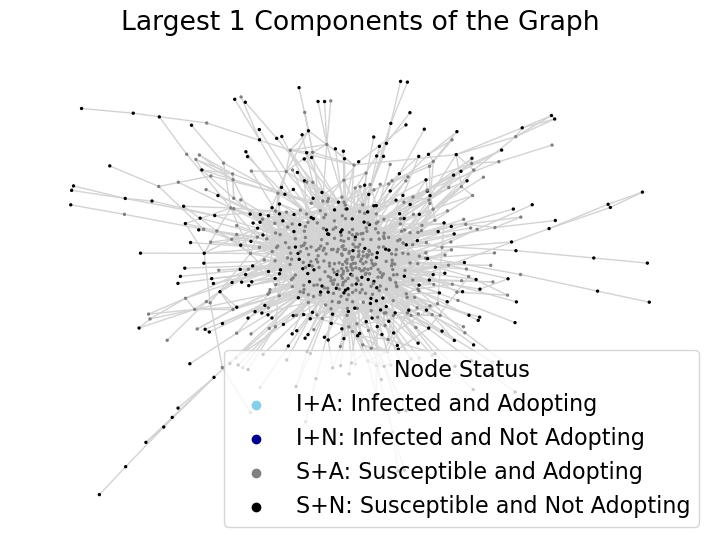

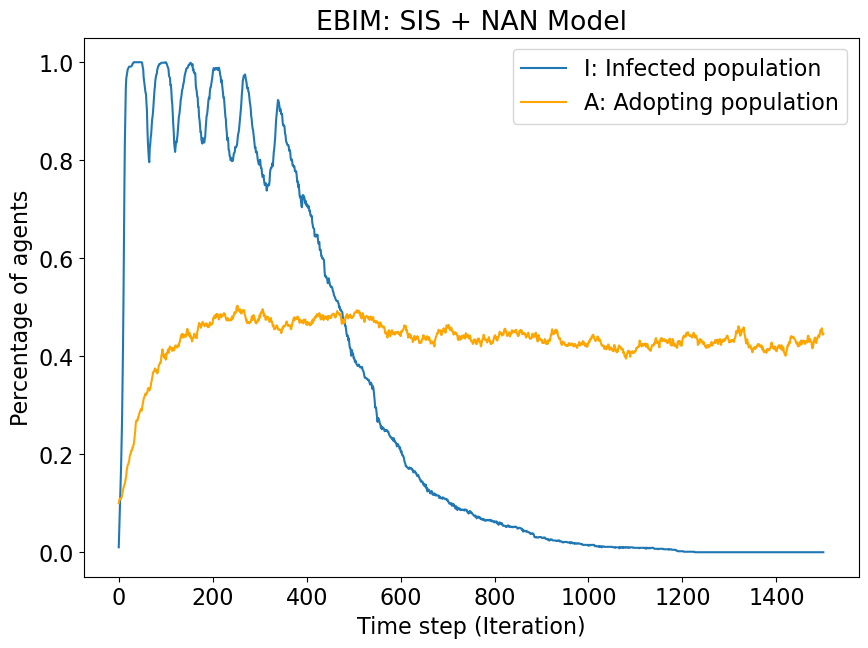

In [34]:
random.seed(111)
np.random.seed(123)

threshold_formula = "simple"
psi = 0.01 # transmission probability for unaware nodes

SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, psi=psi, initial_infected_ratio=0.01, intial_aware_ratio=0.1)
SISModel.run_simulation(time_steps, plot_network=False)

SISModel.plot_network("physical", component_num=1)
SISModel.plot_prevalence_trend()


#### Complex contagion

Parameters: N=1000, k=5, a=1.5, b=1.25, beta_a=0.07083333333333333, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=complex, lambda=0.8, rho=0.5
Number of Infected, Aware: 10, 100
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 6
Clustering coefficient, Transitivity: 0.004568, 0.003849
------------------------------
Parameters: N=1000, k=5, a=1.5, b=1.25, beta_a=0.07083333333333333, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=complex, lambda=0.8, rho=0.5
Number of Infected, Aware: 461, 473
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 71
Clustering coefficient, Transitivity: 0.187059, 0.163740
------------------------------


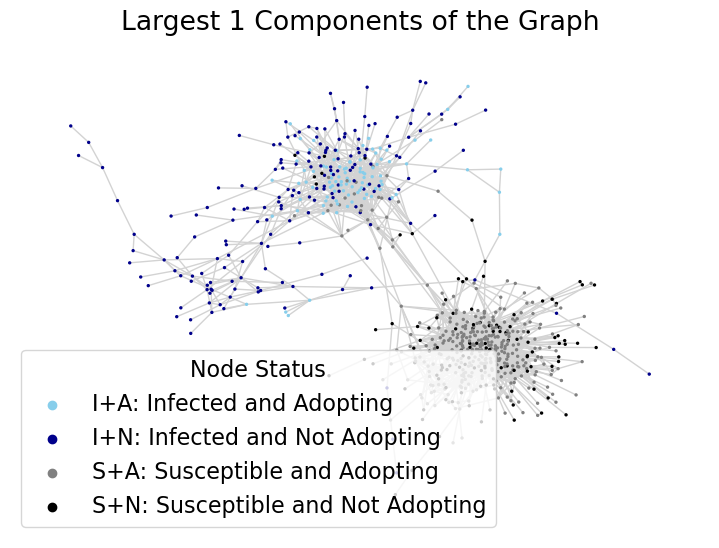

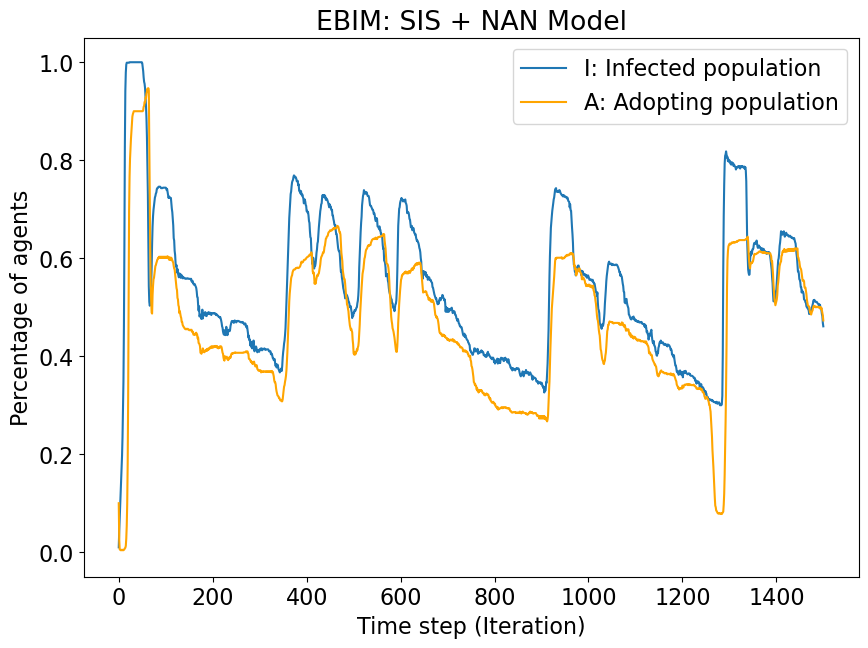

In [35]:
random.seed(111)
np.random.seed(123)

threshold_formula = "complex" # "complex" or "simple" contagion
lambda_ = 0.8 # how the global in fection rate affects the awareness threshold
rho  = 0.5 # turning point of the awareness threshold

SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_=lambda_, rho=rho, initial_infected_ratio=0.01, intial_aware_ratio=0.1)
SISModel.run_simulation(time_steps, plot_network=False)

SISModel.plot_network("physical", component_num=1)
SISModel.plot_prevalence_trend()

## Result 2: Parameters Space (e.g., beta_a, lamda...)

## Result 3: Thredshold Distribution

## Result 4: Network Typology

## Results 5: Rewiring Rates

  ## Result 6: Transitivity

## (Supplementary and Testing)

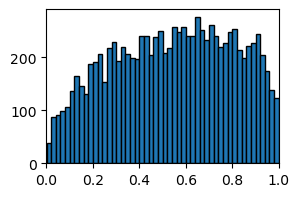

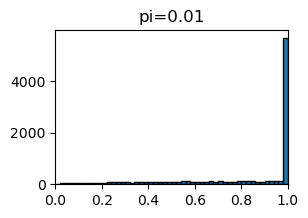

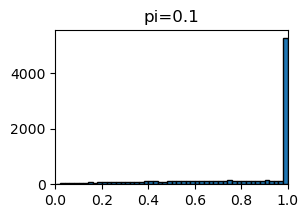

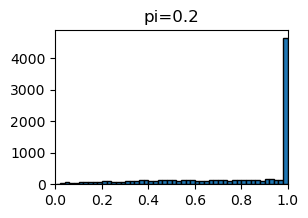

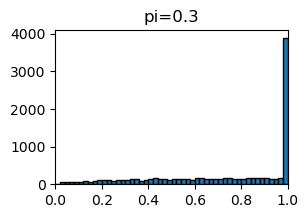

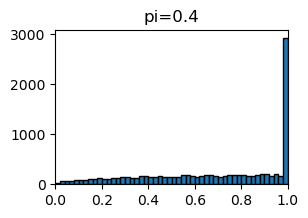

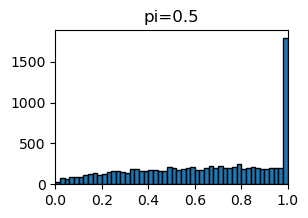

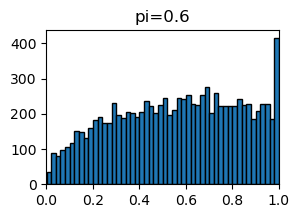

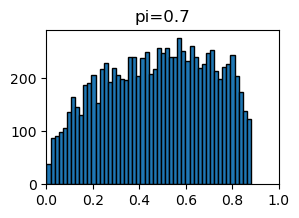

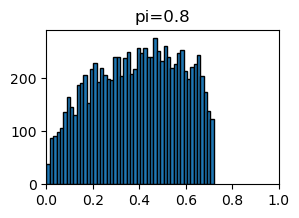

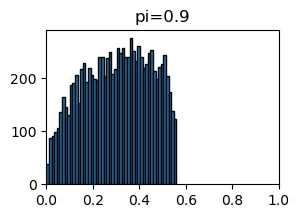

In [195]:
# x = np.random.uniform(0.05, 0.95, 10000)
# x = np.random.normal(0.5, 0.25, 10000)
alpha, beta = 1.5, 1.25
lambda_ = 0.8
rho = 0.5

x = np.random.beta(alpha, beta, 10000)
plt.figure(figsize=(3, 2))
plt.hist(x, bins=50, edgecolor='black')
plt.xlim(0, 1) 
plt.show()
for pi in ([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    plt.figure(figsize=(3, 2))
    plt.hist(np.clip(x*(1-lambda_*pi)*(1/rho), 0, 1), bins=50, edgecolor='black') 
    plt.xlim(0, 1) 
    plt.title(f'pi={pi}')
    plt.show()

[455, 582, 741, 972, 732, 839, 460, 171, 211, 781, 417, 689, 780, 652, 348, 836, 697, 99, 800] [455, 582, 741, 972, 732, 839, 460, 171, 211, 781, 417, 689, 780, 652, 348, 836, 697, 99, 800]


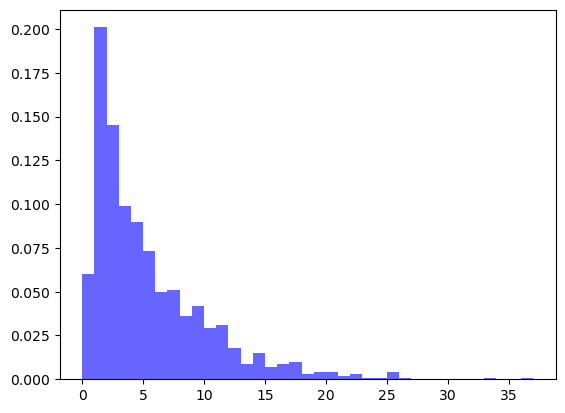

In [159]:
print(SISModel.nodes[1].get_physical_neighbors_id(), SISModel.nodes[1].get_virtual_neighbors_id())

degrees = [degree for _, degree in SISModel.get_network('physical').degree()]
plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
plt.show()

# degrees = [degree for _, degree in SISModel.get_network('virtual').degree()]
# plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
# plt.show()

Parameters: N=100, k=5, a=1.5, b=1.25, beta_a=0.08499999999999999, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=complex, lambda=0.7, rho=0.6
Number of Infected, Aware: 1, 10
Physical, Virtual network: 241, 241 edges
The number of isolated nodes: 1
Clustering coefficient, Transitivity: 0.055699, 0.069409
------------------------------
Time step: 1
Awareness count: 0


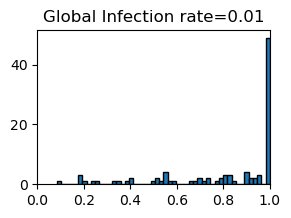

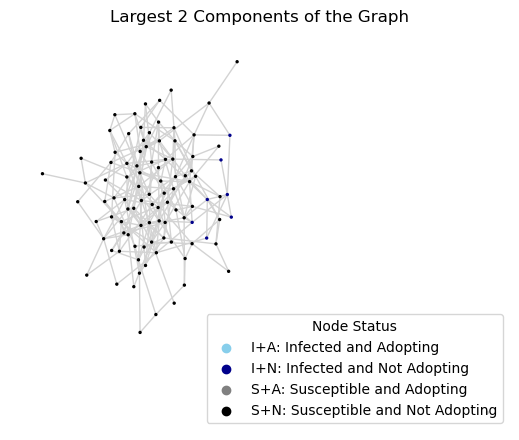

Parameters: N=100, k=5, a=1.5, b=1.25, beta_a=0.08499999999999999, beta_u=0.85, alpha=0.25, infection_period=50, gamma=0.8, eta=0.8, threshold_formula=complex, lambda=0.7, rho=0.6
Number of Infected, Aware: 100, 0
Physical, Virtual network: 241, 241 edges
The number of isolated nodes: 0
Clustering coefficient, Transitivity: 0.199679, 0.180815
------------------------------


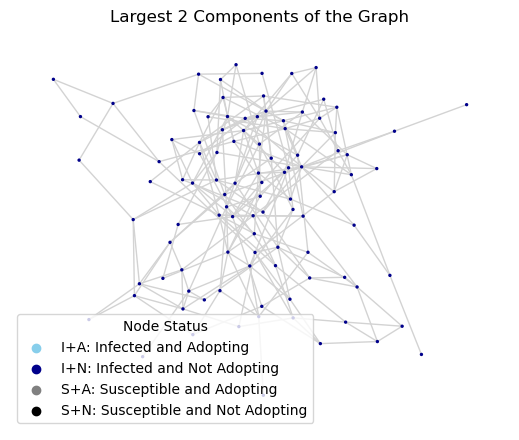

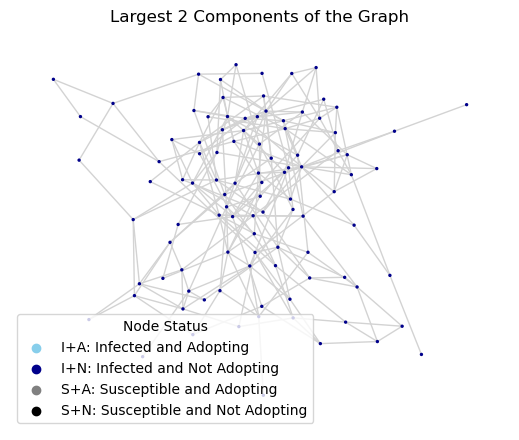

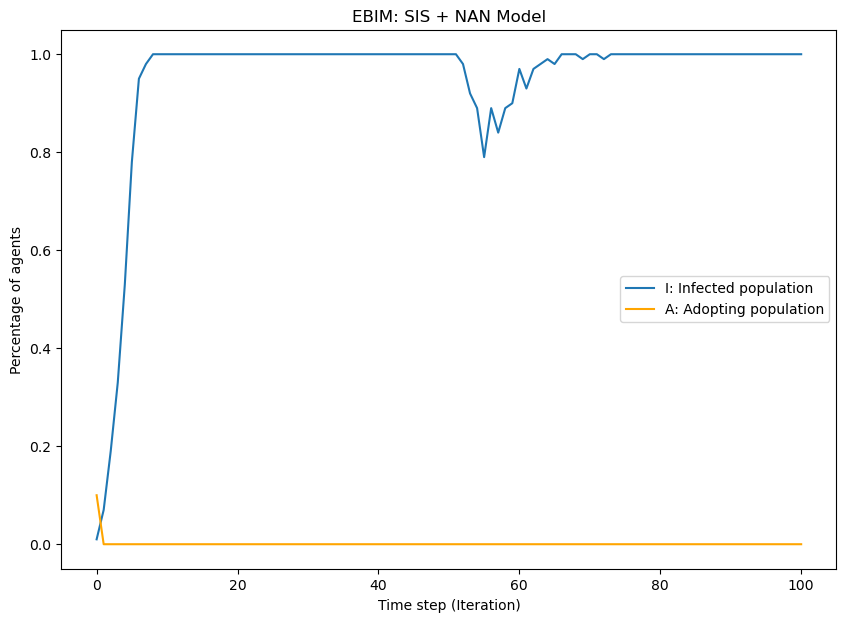

In [167]:
N = 100
k = 5 # average degree
time_steps = 100

a, b = 1.5, 1.25 # beta distribution parameters
beta_u = 0.85 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes
alpha = 0.25 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = 0.8 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.8 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

threshold_formula = "complex" # "complex" or "simple" contagion
lambda_ = 0.7 # how the global infection rate affects the awareness threshold
rho  = 0.6 # turning point of the awareness threshold

SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_=lambda_, rho=rho, initial_infected_ratio=0.01, intial_aware_ratio=0.1)
SISModel.run_simulation(time_steps, print_info=True, plot_network=True)

SISModel.plot_network("physical")
SISModel.plot_network("virtual")
SISModel.plot_prevalence_trend()